<a href="https://colab.research.google.com/github/ChristophWuersch/AppliedNeuralNetworks/blob/main/U01/WoodsMammography-PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="Bilder/ost_logo.png" width="240"  align="right"/>
<div style="text-align: left"> <b> Applied Neural Networks | FS 2025 </b><br>
<a href="mailto:christoph.wuersch@ost.ch"> © Christoph Würsch </a> </div>
<a href="https://www.ost.ch/de/forschung-und-dienstleistungen/technik/systemtechnik/ice-institut-fuer-computational-engineering/"> Eastern Switzerland University of Applied Sciences OST | ICE </a>


# Ein neuronales Netz zur Klassifizierung von Brustkrebs 
### (Woods Mammography Dataset)

Source: https://machinelearningmastery.com/develop-a-neural-network-for-woods-mammography-dataset/

In dieser Übungsaufgabe erfahren Sie, wie Sie ein neuronales Mehrschicht-Perceptron-Netzwerkmodell für den Wood's Mammographie-Klassifizierungsdatensatz entwickeln.

Nach erfolgreichem Abschluss dieser Übungsaufgabe werden Sie wissen:

- Wie man den Wood's Mammography-Datensatz lädt und zusammenfasst und die Ergebnisse nutzt, um Vorschläge für die Datenaufbereitung und die zu verwendenden Modellkonfigurationen zu machen.
- Wie man die Lerndynamik von einfachen MLP-Modellen auf dem Datensatz untersucht.
- Wie man robuste Schätzungen der Modellleistung entwickelt, die Modellleistung abstimmt und Vorhersagen für neue Daten macht.

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## (a) Laden des Datensatzes

Der Datensatz geht auf Kevin Woods et al. und die 1993 veröffentlichte Arbeit mit dem Titel [Comparative Evaluation Of Pattern Recognition Techniques For Detection Of Microcalcifications In Mammography](https://www.worldscientific.com/doi/abs/10.1142/S0218001493000698) zurück.

Jason Brownlee hat auf folgendem GitHub-Ordner noch weitere ML-Datensätze zusammengestellt, die für das Traineren von einfachen ML-Modellen verwendet werden können: https://github.com/jbrownlee/Datasets/tree/master



In [50]:
# load the dataset

#df = pd.read_csv('mammography.csv', header=None)
columns=['f0','f1','f2','f3','f4','f5','label']
df=pd.read_csv('https://raw.githubusercontent.com/ChristophWuersch/AppliedNeuralNetworks/master/U01/mammography.csv', header=None)
df.columns = columns
#infoFile='mammography.names'

df.head()

,f0,f1,f2,f3,f4,f5,label
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,'-1'
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,'-1'
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,'-1'
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,'-1'
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,'-1'


## (b) Plotten von Histogrammen

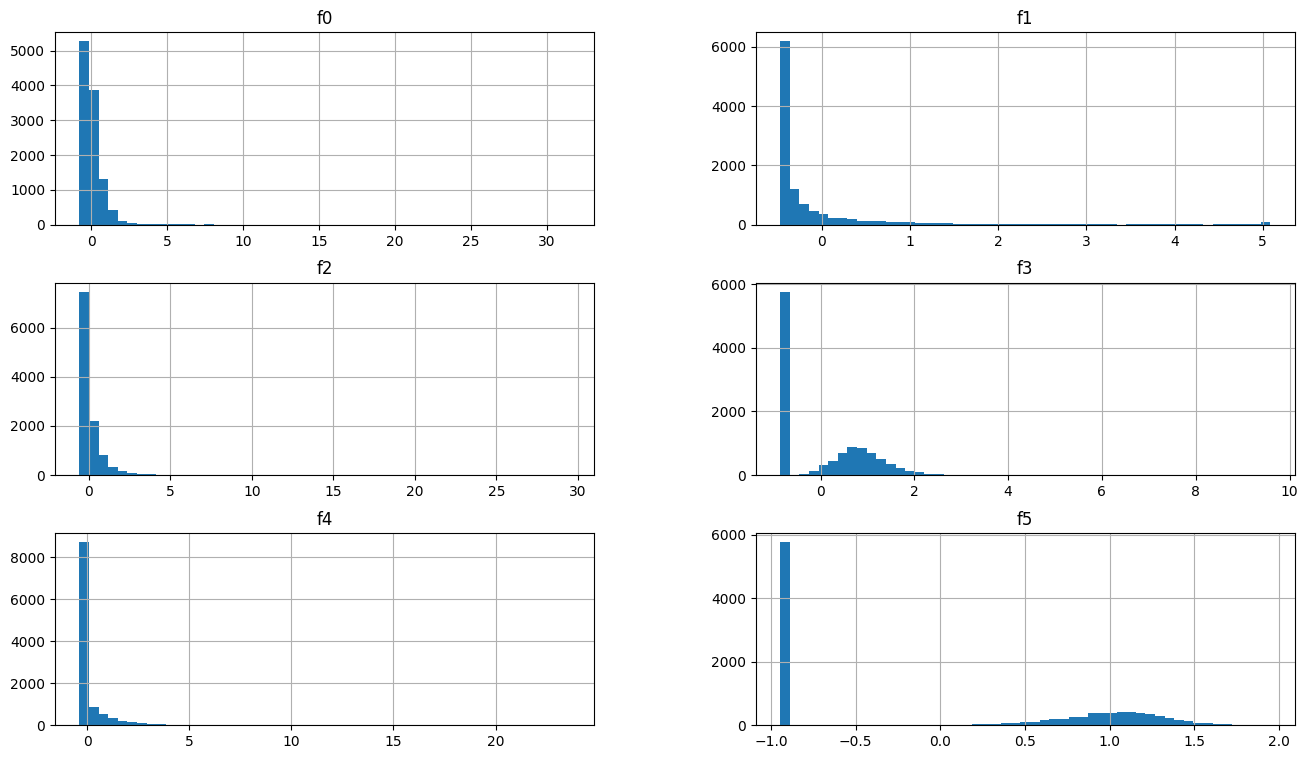

In [51]:
%matplotlib inline
df.hist(bins=51,figsize=(16,9));

- Es ist zu erkennen, dass die meisten Variablen vielleicht eine Exponentialverteilung haben, und vielleicht ist Variable 5 (die letzte Eingabevariable) normalverteilt mit einigen Ausreissern/fehlenden Werten.
- Es könnte von Vorteil sein, eine *Potenztransformation* (`PowerTransformer`) auf jede Variable anzuwenden, um die Wahrscheinlichkeitsverteilung weniger schief zu machen, was die Leistung des Modells wahrscheinlich verbessern wird.

## (c) Label Encoder

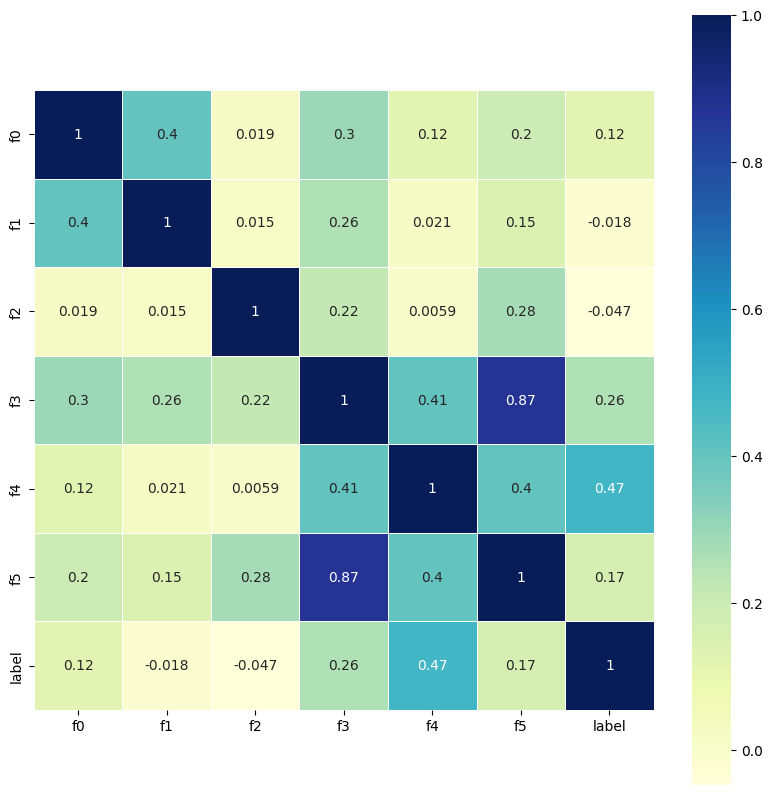

In [52]:
import seaborn as sns
import numpy as np
# split into input and output columns

le=LabelEncoder()

X, y = df.values[:, :-1], df.values[:, -1]
# ensure all data are floating point values
X = X.astype('float32')
# encode strings to integer
y = le.fit_transform(y)
df['label'] = np.float32(y)


fig, ax = plt.subplots(figsize=(10,10))   

sns.heatmap(df.corr(),annot=True,linewidths=.5,cmap="YlGnBu",square=True, ax=ax);

In [53]:
df.isnull().sum()

f0       0
f1       0
f2       0
f3       0
f4       0
f5       0
label    0
dtype: int64

In [54]:
df.describe()

,f0,f1,f2,f3,f4,f5,label
count,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,11183.000000
mean,1.096536e-10,1.297595e-09,5.698113e-10,-2.435706e-09,-1.120680e-09,1.459483e-09,0.023250
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.150695
min,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01,0.000000
25%,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01,0.000000
50%,-1.085769e-01,-3.949941e-01,-2.309790e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01,0.000000
75%,3.139489e-01,-7.649473e-02,2.198366e-01,8.202077e-01,-3.778657e-01,1.016613e+00,0.000000
max,3.150844e+01,5.085849e+00,2.947777e+01,9.591164e+00,2.361712e+01,1.949027e+00,1.000000


## (d) Klasse für Datensatz (`Dataset`) und `DataLoader`

In [61]:
# Split into features (X) and target (y)
X = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32).to(device)
y = torch.tensor(df.iloc[:, -1].values, dtype=torch.float32).to(device)  # Use long for class indices



In [56]:

# Custom Dataset class
class MammographyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset and split into train and validation sets
dataset = MammographyDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [57]:
#determine the number of input features
n_features = X.shape[1]
print('Input Features: %i' % (n_features))

Input Features: 6


## (e) Modell erstellen und kompilieren


In [58]:

# Determine the number of input features
n_features = X.shape[1]
print('Input Features:', n_features)

# Define the neural network model
class Net(nn.Module):
    def __init__(self, n_features,n_hidden=64):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout layer after fc1
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.dropout2 = nn.Dropout(p=0.5)  # Dropout layer after fc2
        self.fc3 = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout after activation
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after activation
        x = torch.sigmoid(self.fc3(x))
        return x

model = Net(n_features).to(device)

# Print model architecture
print(model)

Input Features: 6
Net(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


## (f) Definiere den Optimierer und die Verlustfunktion (loss function)

In [59]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

## (g) Training für 100 Epochen

In [60]:

# Training loop
epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.float().unsqueeze(1))  # Ensure target is float for BCELoss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predicted = (output > 0.5).float()
        train_total += target.size(0)
        train_correct += (predicted == target.float().unsqueeze(1)).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            output = model(data)
            loss = criterion(output, target.float().unsqueeze(1))
            val_loss += loss.item()
            predicted = (output > 0.5).float()
            val_total += target.size(0)
            val_correct += (predicted == target.float().unsqueeze(1)).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')


Epoch [1/100], Train Loss: 0.1744, Train Acc: 97.33%, Val Loss: 0.0752, Val Acc: 97.94%
Epoch [2/100], Train Loss: 0.0808, Train Acc: 97.89%, Val Loss: 0.0647, Val Acc: 98.21%
Epoch [3/100], Train Loss: 0.0719, Train Acc: 98.09%, Val Loss: 0.0591, Val Acc: 98.39%
Epoch [4/100], Train Loss: 0.0667, Train Acc: 98.27%, Val Loss: 0.0579, Val Acc: 98.44%
Epoch [5/100], Train Loss: 0.0663, Train Acc: 98.35%, Val Loss: 0.0569, Val Acc: 98.30%
Epoch [6/100], Train Loss: 0.0650, Train Acc: 98.25%, Val Loss: 0.0562, Val Acc: 98.48%
Epoch [7/100], Train Loss: 0.0633, Train Acc: 98.26%, Val Loss: 0.0562, Val Acc: 98.39%
Epoch [8/100], Train Loss: 0.0607, Train Acc: 98.39%, Val Loss: 0.0560, Val Acc: 98.39%
Epoch [9/100], Train Loss: 0.0585, Train Acc: 98.48%, Val Loss: 0.0553, Val Acc: 98.57%
Epoch [10/100], Train Loss: 0.0613, Train Acc: 98.30%, Val Loss: 0.0553, Val Acc: 98.44%
Epoch [11/100], Train Loss: 0.0593, Train Acc: 98.35%, Val Loss: 0.0554, Val Acc: 98.44%
Epoch [12/100], Train Loss: 0.

## (h) Modell speichern

In [43]:

# Save the trained model
torch.save(model.state_dict(), 'mammography_model.pth')

# Load the saved model
model = Net(n_features).to(device)
model.load_state_dict(torch.load('mammography_model.pth'))



Predicted: '-1'


## (i) Lernkurven darstellen

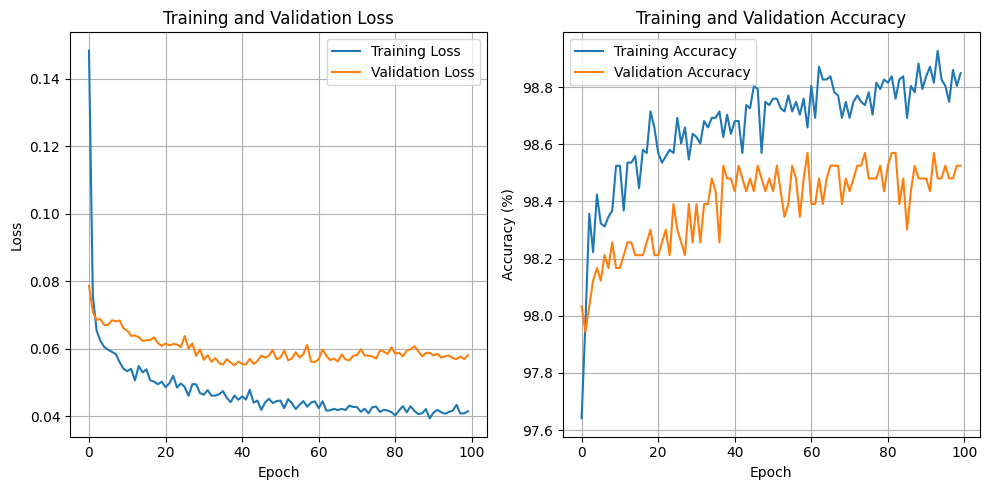

In [46]:

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## (j) Endgültiges Modell und Vorhersagen machen

Sobald wir uns für eine Modellkonfiguration entschieden haben, können wir ein endgültiges Modell auf allen verfügbaren Daten trainieren und es verwenden, um Vorhersagen für neue Daten zu treffen.

In diesem Fall verwenden wir das Modell mit Dropout und einer kleinen Losgröße als endgültiges Modell.

Wir können die Daten vorbereiten und das Modell wie zuvor anpassen, allerdings mit dem gesamten Datensatz anstelle einer Trainingsuntermenge des Datensatzes.

In [48]:
# fit a final model and make predictions on new data for the mammography dataset

# define a row of new data
row = [0.23001961,5.0725783,-0.27606055,0.83244412,-0.37786573,0.4803223]

# Make prediction on new data
row = torch.tensor(row, dtype=torch.float32).to(device)
yhat = (model(row) > 0.5).int().item()
yhat = le.inverse_transform([yhat])
print('Predicted:', yhat[0])

Predicted: '-1'
